In [1]:
import glob
import os
from os import path

import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Directories

In [2]:
# Define temp directory
input_dir = "data/raw/"# input data directory
dest_dir = "data/temp/"# output data directory

# REMOVE invisible DS_Store file (mac issue) - do it ONCE only
list_dir = ['data/output/.DS_Store',
            'data/output/prep_regr_tabs/.DS_Store',
            'data/output/regressions/.DS_Store',
            'data/output/regressions/controlled_Climate/.DS_Store',
            'data/output/regressions/controlled_WatSanEdu/.DS_Store',
            'data/output/regressions/GWR/.DS_Store',
            'data/output/regressions/NON_controlled/.DS_Store',
            'data/output/regressions/sp_autocorr/.DS_Store',
            'data/raw/.DS_Store',
            'data/raw/dhs/.DS_Store',
            'data/raw/dhs/CIGE61FL/.DS_Store',
            'data/raw/dhs/CIKR62DT_children/.DS_Store',
            'data/raw/osm/.DS_Store',
            'data/raw/osm/input/.DS_Store',
            'data/raw/osm/output/.DS_Store',
            'data/raw/raster_to_clip/.DS_Store',
            'data/temp/.DS_Store']

for f_dir in list_dir:
    if os.path.exists(f_dir)==True:
        os.remove(f_dir)

# DHS data

### Retrieve children questionnaire data

In [3]:
# Convert .dta file
dhs_civ_df_kr = pd.read_stata(path.join(input_dir,"dhs/CIKR62DT_children/CIKR62FL.DTA"),convert_categoricals=False)
dhs_civ_df_kr

,caseid,midx,v000,v001,v002,v003,v004,v005,v006,v007,...,s1221f,idx94,s423a,s423b,s446a,idx95,s506y,sd506y,sm506y,sy506y
0,1 1 1,1,CI6,1,1,1,1,1803150,5,2012,...,0.0,1,11.0,9998.0,2.0,1,0,NaN,NaN,NaN
1,1 6 3,1,CI6,1,6,3,1,1803150,1,2012,...,0.0,1,NaN,NaN,NaN,1,0,NaN,NaN,NaN
2,1 7 2,1,CI6,1,7,2,1,1803150,1,2012,...,0.0,1,22.0,1275.0,2.0,1,2,NaN,NaN,NaN
3,1 16 3,1,CI6,1,16,3,1,1803150,1,2012,...,0.0,1,NaN,NaN,NaN,1,0,NaN,NaN,NaN
4,1 16 3,2,CI6,1,16,3,1,1803150,1,2012,...,0.0,2,NaN,NaN,NaN,2,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,352 46 2,1,CI6,352,46,2,352,604654,1,2012,...,NaN,1,22.0,1080.0,1.0,1,0,NaN,NaN,NaN
7772,352 46 4,1,CI6,352,46,4,352,604654,1,2012,...,0.0,1,NaN,NaN,NaN,1,0,NaN,NaN,NaN
7773,352 46 4,2,CI6,352,46,4,352,604654,1,2012,...,0.0,2,NaN,NaN,NaN,2,0,NaN,NaN,NaN
7774,352 47 2,1,CI6,352,47,2,352,604654,1,2012,...,0.0,1,NaN,NaN,1.0,1,1,1.0,4.0,2008.0


N° households w/ children under-5: 5431
N° clusters: 351
dtype cluster name var: int16
min: 1
max: 352
Histogram of answers to diarrhoea question (by code):


<AxesSubplot:>

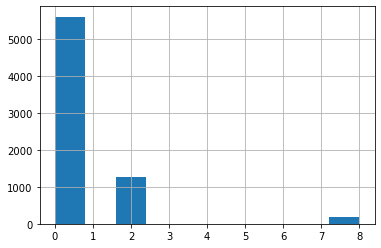

In [4]:
# N° households & clusters
print("N° households w/ children under-5:",dhs_civ_df_kr['caseid'].unique().shape[0])
print("N° clusters:",dhs_civ_df_kr['v001'].unique().shape[0])
print("dtype cluster name var:",dhs_civ_df_kr['v001'].dtype)
print("min:",dhs_civ_df_kr['v001'].unique().min())
print("max:",dhs_civ_df_kr['v001'].unique().max())

# See answers for diarrhoea
print("Histogram of answers to diarrhoea question (by code):")
dhs_civ_df_kr.h11.hist()#histogram with answers to diarrhoea question

In [5]:
# Prevalence of diarrhoea (excluding invalid obs. & non-'de jure' residents)

# Subset groups (valid obs. & 'de jure' residents only)
cases_subset = dhs_civ_df_kr[['v001','v005','h11']][(dhs_civ_df_kr['h11'].isin([1,2])) # 1: diarrhoea in last 24h / 2: diarrhoea in last 2 weeks
                                                    &(~dhs_civ_df_kr['v139'].isin([97,99])) # 97: not de jure resident / 99: missing info
                                                   ]
cases_subset['n_count'] = 1
cases_subset['n_count'] = cases_subset['n_count'].astype('int')
n_cases = cases_subset.n_count.sum()
pop_subset = dhs_civ_df_kr[['v001','v005','h11']][(dhs_civ_df_kr['h11'].isin([0,1,2]))
                                                  &(~dhs_civ_df_kr['v139'].isin([97,99]))
                                                 ]
pop_subset['wt'] = pop_subset['v005']/1000000
pop_subset['n_count'] = 1
pop_subset['n_count'] = pop_subset['n_count'].astype('int')
n_pop = pop_subset.n_count.sum()
print("Under-5 population (unweighted, valid obs.):",n_pop)
print("N° cases (unweighted, valid obs.):",n_cases,"(",(n_cases/n_pop)*100,"%)")

# Excluded observations
# Don't know
print("--------------------- EXCLUDED OBS. ---------------------")
n_dont_know = dhs_civ_df_kr[dhs_civ_df_kr['h11']==8].shape[0]
print("Don't know (excluded from analysis):",n_dont_know)
# Non-applicable / missing obs.
n_missing_or_na = dhs_civ_df_kr['h11'].isna().sum()+dhs_civ_df_kr[dhs_civ_df_kr['h11']==9].shape[0]
print("Missing or not applicable (excluded from analysis):",n_missing_or_na)
# Not de jure resident
n_not_dejure = dhs_civ_df_kr[(dhs_civ_df_kr['v139'].isin([97,99]))&
                             (~dhs_civ_df_kr['h11'].isin([8,9]))&
                             (~dhs_civ_df_kr['h11'].isna())
                            ].shape[0]
print("Not de jure resident (excluded from analysis):",n_not_dejure)

Under-5 population (unweighted, valid obs.): 6732
N° cases (unweighted, valid obs.): 1247 ( 18.523469994058228 %)
--------------------- EXCLUDED OBS. ---------------------
Don't know (excluded from analysis): 176
Missing or not applicable (excluded from analysis): 724
Not de jure resident (excluded from analysis): 144


In [6]:
# Prevalence of diarrhoea (excluding invalid obs. only)

# Subset groups (valid obs. only)
cases_subset_bis = dhs_civ_df_kr[['v001','v005','h11']][(dhs_civ_df_kr['h11'].isin([1,2]))] # 1: diarrhoea in last 24h / 2: diarrhoea in last 2 weeks
cases_subset_bis['n_count'] = 1
cases_subset_bis['n_count'] = cases_subset_bis['n_count'].astype('int')
n_cases_bis = cases_subset_bis.n_count.sum()
pop_subset_bis = dhs_civ_df_kr[['v001','v005','h11']][(dhs_civ_df_kr['h11'].isin([0,1,2]))]
pop_subset_bis['n_count'] = 1
pop_subset_bis['n_count'] = pop_subset_bis['n_count'].astype('int')
n_pop_bis = pop_subset_bis.n_count.sum()
print("Under-5 population (unweighted, valid obs.):",n_pop_bis)
print("N° cases (unweighted, valid obs.):",n_cases_bis,"(",(n_cases_bis/n_pop_bis)*100,"%)")

# Excluded observations
# Don't know
print("--------------------- EXCLUDED OBS. ---------------------")
n_dont_know = dhs_civ_df_kr[dhs_civ_df_kr['h11']==8].shape[0]
print("Don't know (excluded from analysis):",n_dont_know)
# Non-applicable / missing obs.
n_missing_or_na = dhs_civ_df_kr['h11'].isna().sum()+dhs_civ_df_kr[dhs_civ_df_kr['h11']==9].shape[0]
print("Missing or not applicable (excluded from analysis):",n_missing_or_na)

Under-5 population (unweighted, valid obs.): 6876
N° cases (unweighted, valid obs.): 1276 ( 18.557300756253635 %)
--------------------- EXCLUDED OBS. ---------------------
Don't know (excluded from analysis): 176
Missing or not applicable (excluded from analysis): 724


### Retrieve household questionnaire data

In [7]:
# Convert .dta file
dhs_civ_df_hr = pd.read_stata(path.join(input_dir,"dhs/CIHR62DT_household/CIHR62FL.DTA"),convert_categoricals=False)
dhs_civ_df_hr

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,...,chl8_08,chl8_09,chl8_10,chl8_11,chl8_12,chl8_13,chl8_14,chl8_15,chl8_16,chl8_17
0,1 1,CI6,1,1,1,1,1817406,5,2012,1349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 6,CI6,1,6,3,1,1817406,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 7,CI6,1,7,2,1,1817406,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 10,CI6,1,10,1,1,1817406,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 11,CI6,1,11,2,1,1817406,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,352 43,CI6,352,43,1,352,620842,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9682,352 45,CI6,352,45,1,352,620842,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9683,352 46,CI6,352,46,1,352,620842,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9684,352 47,CI6,352,47,2,352,620842,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Describe clusters

# Median number of participants (surveyed household members) in each cluster
print('Median n° of participants',dhs_civ_df_hr[['hv001','hv012']].groupby(['hv001']).sum().hv012.median())

# Median number of surveyed households in each cluster
print('Median n° of households',dhs_civ_df_hr[['hv001','hhid']].groupby(['hv001']).count().hhid.median())

Median n° of participants 134.0
Median n° of households 27.0


In [8]:
# N° households & clusters
print("N° households interviewed:",dhs_civ_df_hr['hhid'].unique().shape[0])
print("N° clusters:",dhs_civ_df_hr['hv001'].unique().shape[0])
print("dtype cluster name var:",dhs_civ_df_hr['hv001'].dtype)
print("min:",dhs_civ_df_hr['hv001'].unique().min())
print("max:",dhs_civ_df_hr['hv001'].unique().max())

N° households interviewed: 9686
N° clusters: 351
dtype cluster name var: int16
min: 1
max: 352


In [9]:
# Source of drinking water (1)

# Recoding info: https://dhsprogram.com/Data/Guide-to-DHS-Statistics/index.cfm
# Water: https://dhsprogram.com/data/Guide-to-DHS-Statistics/index.htm#t=Household_Drinking_Water.htm

# IMPROVED water subset
imp_wat_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv201']][dhs_civ_df_hr['hv201'].isin([11, 12, 13, 14, 21, 31, 41, 51, 61, 62, 71])]
imp_wat_df['hh_count'] = 1
imp_wat_df['hh_hab'] = dhs_civ_df_hr['hv012']# people that usually live in the surveyed household ('hv012')

# Unimproved water subset
unimp_wat_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv201']][dhs_civ_df_hr['hv201'].isin([32, 42, 43, 96])]
unimp_wat_df['hh_count'] = 1
unimp_wat_df['hh_hab'] = unimp_wat_df['hv012']

# Check that there are no overlaps (improved/unimproved categories must be exclusive)
if len(list(set(imp_wat_df.hhid.to_list()) & set(unimp_wat_df.hhid.to_list())))>0:
    print("overlapping hhid n° between imp & unimp. water")
else:
    print("No overlap; recoding improved/unimproved OK!")

# Stats on access to improved water (households, UNWEIGHTED)
n_imp_hh = imp_wat_df.hh_count.sum()
n_unimp_hh = unimp_wat_df.hh_count.sum()
print("Households with access to improved water (unweighted n°):",
      n_imp_hh,"(",
      (n_imp_hh/(n_imp_hh+n_unimp_hh))*100,"%)")
print("Households with unimproved water (unweighted n°):",
      n_unimp_hh,"(",
      (n_unimp_hh/(n_imp_hh+n_unimp_hh))*100,"%)")

# Stats on access to improved water (individuals, UNWEIGHTED)
n_imp_pop = imp_wat_df.hh_hab.sum()
n_unimp_pop = unimp_wat_df.hh_hab.sum()
print("Population with access to improved water (unweighted n°):",
      n_imp_pop,"(",
      (n_imp_pop/(n_imp_pop+n_unimp_pop))*100,"%)")
print("Population with unimproved water (unweighted n°):",
      n_unimp_pop,"(",
      (n_unimp_pop/(n_imp_pop+n_unimp_pop))*100,"%)")

# Excluded obs.
print("Observations excluded from calculation (info missing):",
      dhs_civ_df_hr[dhs_civ_df_hr['hv201'].isin([97,99])].shape[0]+dhs_civ_df_hr[dhs_civ_df_hr['hv201'].isna()].shape[0])

No overlap; recoding improved/unimproved OK!
Households with access to improved water (unweighted n°): 7681 ( 79.35737162930054 %)
Households with unimproved water (unweighted n°): 1998 ( 20.642628370699452 %)
Population with access to improved water (unweighted n°): 40029 ( 79.54414482443416 %)
Population with unimproved water (unweighted n°): 10294 ( 20.455855175565844 %)
Observations excluded from calculation (info missing): 7


In [10]:
# Source of drinking water (2)

# BASIC water subset (improved source, within 30 min. both ways)
bas_wat_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv201','hv204']][(dhs_civ_df_hr['hv201'].isin([11, 12, 13, 14, 21, 31, 41, 51, 61, 62, 71]))
                                                                             &((dhs_civ_df_hr['hv204']<=30)|(dhs_civ_df_hr['hv204']==996))]
bas_wat_df['hh_count'] = 1
bas_wat_df['hh_hab'] = dhs_civ_df_hr['hv012']# people that usually live in the surveyed household ('hv012')

# Non-Basic water subset
nobas_wat_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv201','hv204']][((dhs_civ_df_hr['hv201'].isin([32, 42, 43, 96]))
                                                                                |((((dhs_civ_df_hr['hv204']>30)&(dhs_civ_df_hr['hv204']<501))
                                                                                  |(dhs_civ_df_hr['hv204'].isin([998,999])))
                                                                                  &(~dhs_civ_df_hr['hv201'].isna())))]
nobas_wat_df['hh_count'] = 1
nobas_wat_df['hh_hab'] = nobas_wat_df['hv012']

# Check that there are no overlaps (improved/unimproved categories must be exclusive)
if len(list(set(bas_wat_df.hhid.to_list()) & set(nobas_wat_df.hhid.to_list())))>0:
    print("overlapping hhid n° between basic & not basic water")
else:
    print("No overlap; recoding improved/unimproved OK!")

# Stats on access to BASIC water (households, UNWEIGHTED)
n_bas_hh = bas_wat_df.hh_count.sum()
n_nobas_hh = nobas_wat_df.hh_count.sum()
print("Households with access to BASIC water (unweighted n°):",
      n_bas_hh,"(",
      (n_bas_hh/(n_bas_hh+n_nobas_hh))*100,"%)")
print("Households WITHOUT access to basic water (unweighted n°):",
      n_nobas_hh,"(",
      (n_nobas_hh/(n_bas_hh+n_nobas_hh))*100,"%)")

# Stats on access to BASIC water (individuals, UNWEIGHTED)
n_bas_pop = bas_wat_df.hh_hab.sum()
n_nobas_pop = nobas_wat_df.hh_hab.sum()
print("Population with access to improved water (unweighted n°):",
      n_bas_pop,"(",
      (n_bas_pop/(n_bas_pop+n_nobas_pop))*100,"%)")
print("Population with unimproved water (unweighted n°):",
      n_nobas_pop,"(",
      (n_nobas_pop/(n_bas_pop+n_nobas_pop))*100,"%)")

# Excluded obs.
print("Observations excluded from calculation (info missing):",
      9686-(n_bas_hh+n_nobas_hh))

No overlap; recoding improved/unimproved OK!
Households with access to BASIC water (unweighted n°): 7047 ( 72.84473847426091 %)
Households WITHOUT access to basic water (unweighted n°): 2627 ( 27.155261525739093 %)
Population with access to improved water (unweighted n°): 36302 ( 72.17240899421459 %)
Population with unimproved water (unweighted n°): 13997 ( 27.8275910057854 %)
Observations excluded from calculation (info missing): 12


In [11]:
# Type of toilet facility (1)

# Recoding info: https://dhsprogram.com/Data/Guide-to-DHS-Statistics/index.cfm
# Sanitation: https://dhsprogram.com/data/Guide-to-DHS-Statistics/index.htm#t=Type_of_Sanitation_Facility.htm

# Improved sanitation >> excludes "flush don't know where" (eventhough DHS recoding includes this category)
# NOTE: only 4 obs. for "flush don't know where"
imp_san_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv205']][dhs_civ_df_hr['hv205'].isin([11, 12, 13, 21, 22, 41])]
imp_san_df['hh_count'] = 1
imp_san_df['hh_hab'] = imp_san_df['hv012']

# Non-improved sanitation >> includes: flush don't know where ('hv205'==15) + open defecation ('hv205'==31)
# NOTE: only 4 obs. for "flush don't know where"
unimp_san_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv205']][dhs_civ_df_hr['hv205'].isin([14, 15, 23, 31, 42, 43, 96])]
unimp_san_df['hh_count'] = 1
unimp_san_df['hh_hab'] = unimp_san_df['hv012']

# Check that there are no overlaps (improved/unimproved categories must be exclusive)
if len(list(set(imp_san_df.hhid.to_list()) & set(unimp_san_df.hhid.to_list())))>0:
    print("overlapping hhid n° between imp & not imp. sanitation")
else:
    print("No overlap; recoding improved/not improved OK!")

# Stats on access to improved sanitation (households, UNWEIGHETED)
n_imps_hh = imp_san_df.hh_count.sum()
n_unimps_hh = unimp_san_df.hh_count.sum()
print("Households with access to improved sanitation (unweighted n°):",
      n_imps_hh,"(",
      (n_imps_hh/(n_imps_hh+n_unimps_hh))*100,"%)")
print("Households without access to improved sanitation (unweighted n°):",
      n_unimps_hh,"(",
      (n_unimps_hh/(n_imps_hh+n_unimps_hh))*100,"%)")

# Stats on access to improved sanitation (individuals, UNWEIGHETED)
n_imps_pop = imp_san_df.hh_hab.sum()
n_unimps_pop = unimp_san_df.hh_hab.sum()
print("Population with access to improved sanitation (unweighted n°):",
      n_imps_pop,"(",
      (n_imps_pop/(n_imps_pop+n_unimps_pop))*100,"%)")
print("Population without access to improved sanitation (unweighted n°):",
      n_unimps_pop,"(",
      (n_unimps_pop/(n_imps_pop+n_unimps_pop))*100,"%)")

# Excluded obs:
print("Observations excluded from calculation (info missing):",
      dhs_civ_df_hr[dhs_civ_df_hr['hv205'].isin([99])].shape[0]+dhs_civ_df_hr[dhs_civ_df_hr['hv205'].isna()].shape[0])

No overlap; recoding improved/not improved OK!
Households with access to improved sanitation (unweighted n°): 4398 ( 45.509105960264904 %)
Households without access to improved sanitation (unweighted n°): 5266 ( 54.490894039735096 %)
Population with access to improved sanitation (unweighted n°): 22912 ( 45.588761988141194 %)
Population without access to improved sanitation (unweighted n°): 27346 ( 54.411238011858806 %)
Observations excluded from calculation (info missing): 22


In [12]:
# Type of toilet facility (2)

# Basic sanitation >> 'improved' excludes "flush don't know where" (eventhough DHS recoding includes this category)
# NOTE: only 4 obs. for "flush don't know where"
bas_san_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv205','hv225']][(dhs_civ_df_hr['hv205'].isin([11, 12, 13, 21, 22, 41]))&
                                                                             (dhs_civ_df_hr['hv225']==0)]
bas_san_df['hh_count'] = 1
bas_san_df['hh_hab'] = bas_san_df['hv012']

# Non-basic sanitation >> 'unimproved' includes: flush don't know where ('hv205'==15) + open defecation ('hv205'==31)
# NOTE: only 4 obs. for "flush don't know where"
nobas_san_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv205','hv225']][((dhs_civ_df_hr['hv205'].isin([14, 15, 23, 31, 42, 43, 96]))|(dhs_civ_df_hr['hv225']==1))
                                                                               &(~dhs_civ_df_hr['hv205'].isna())]
nobas_san_df['hh_count'] = 1
nobas_san_df['hh_hab'] = nobas_san_df['hv012']

# Check that there are no overlaps (improved/unimproved categories must be exclusive)
if len(list(set(bas_san_df.hhid.to_list()) & set(nobas_san_df.hhid.to_list())))>0:
    print("overlapping hhid n° between imp & not imp. sanitation")
else:
    print("No overlap; recoding improved/not improved OK!")

# Stats on access to improved sanitation (households, UNWEIGHETED)
n_bass_hh = bas_san_df.hh_count.sum()
n_nobass_hh = nobas_san_df.hh_count.sum()
print("Households with access to BASIC sanitation (unweighted n°):",
      n_bass_hh,"(",
      (n_bass_hh/(n_bass_hh+n_nobass_hh))*100,"%)")
print("Households WITHOUT access to basic sanitation (unweighted n°):",
      n_nobass_hh,"(",
      (n_nobass_hh/(n_bass_hh+n_nobass_hh))*100,"%)")

# Stats on access to improved sanitation (individuals, UNWEIGHETED)
n_bass_pop = bas_san_df.hh_hab.sum()
n_nobass_pop = nobas_san_df.hh_hab.sum()
print("Population with access to BASIC sanitation (unweighted n°):",
      n_bass_pop,"(",
      (n_bass_pop/(n_bass_pop+n_nobass_pop))*100,"%)")
print("Population WITHOUT access to basic sanitation (unweighted n°):",
      n_nobass_pop,"(",
      (n_nobass_pop/(n_bass_pop+n_nobass_pop))*100,"%)")

# Excluded obs.
print("Observations excluded from calculation (info missing):",
      9686-(n_bass_hh+n_nobass_hh))

No overlap; recoding improved/not improved OK!
Households with access to BASIC sanitation (unweighted n°): 1687 ( 17.494555636212798 %)
Households WITHOUT access to basic sanitation (unweighted n°): 7956 ( 82.5054443637872 %)
Population with access to BASIC sanitation (unweighted n°): 10608 ( 21.152542372881356 %)
Population WITHOUT access to basic sanitation (unweighted n°): 39542 ( 78.84745762711864 %)
Observations excluded from calculation (info missing): 43


In [13]:
# Place for washing hands, with water and soap available

# Subset groups
imp_hyg_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv230a','hv230a','hv230b','hv232']][((dhs_civ_df_hr['hv230a']==1)&
                                                                                          (dhs_civ_df_hr['hv230b']==1)&
                                                                                          (dhs_civ_df_hr['hv232']==1))]
unimp_hyg_df = dhs_civ_df_hr[['hhid','hv001','hv005','hv012','hv230a']][(dhs_civ_df_hr['hv230a']!=1)&
                                                                        (dhs_civ_df_hr['hv230a']!=9)&
                                                                        (~dhs_civ_df_hr['hv230a'].isna())]
imp_hyg_df['hh_count'] = 1
imp_hyg_df['hh_hab'] = imp_hyg_df['hv012']

unimp_hyg_df['hh_count'] = 1
unimp_hyg_df['hh_hab'] = unimp_hyg_df['hv012']

# Check that there are no overlaps (safely managed/other categories must be exclusive)
if len(list(set(imp_hyg_df.hhid.to_list()) & set(unimp_hyg_df.hhid.to_list())))>0:
    print("overlapping hhid n° between safe & not safe hygiene")
else:
    print("No overlap; recoding safe/not safe OK!")

# Stats on access to safely managed hygiene (households, UNWEIGHETED)
n_imph_hh = imp_hyg_df.hh_count.sum()
n_unimph_hh = unimp_hyg_df.hh_count.sum()
print("Households with access to safe hygiene (unweighted n°):",
      n_imph_hh,"(",
      (n_imph_hh/(n_imph_hh+n_unimph_hh))*100,"%)")
print("Households without access to safe hygiene (unweighted n°):",
      n_unimph_hh,"(",
      (n_unimph_hh/(n_imph_hh+n_unimph_hh))*100,"%)")

# Stats on access to safely managed hygiene (individuals, UNWEIGHETED)
n_imph_pop = imp_hyg_df.hh_hab.sum()
n_unimph_pop = unimp_hyg_df.hh_hab.sum()
print("Population with access to safe hygiene (unweighted n°):",
      n_imph_pop,"(",
      (n_imph_pop/(n_imph_pop+n_unimph_pop))*100,"%)")
print("Population without access to safe hygiene (unweighted n°):",
      n_unimph_pop,"(",
      (n_unimph_pop/(n_imph_pop+n_unimph_pop))*100,"%)")

No overlap; recoding safe/not safe OK!
Households with access to safe hygiene (unweighted n°): 1118 ( 18.055555555555554 %)
Households without access to safe hygiene (unweighted n°): 5074 ( 81.94444444444444 %)
Population with access to safe hygiene (unweighted n°): 6271 ( 19.552881017710153 %)
Population without access to safe hygiene (unweighted n°): 25801 ( 80.44711898228985 %)


### Retrieve women's questionnaire data

In [14]:
# Convert .dta file
dhs_civ_df_ir = pd.read_stata(path.join(input_dir,"dhs/CIIR62DT_ind_women/CIIR62FL.DTA"),convert_categoricals=False)
dhs_civ_df_ir

,caseid,v000,v001,v002,v003,v004,v005,v006,v007,v008,...,sm506y_3,sm506y_4,sm506y_5,sm506y_6,sy506y_1,sy506y_2,sy506y_3,sy506y_4,sy506y_5,sy506y_6
0,1 1 1,CI6,1,1,1,1,1803150,5,2012,1349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 6 3,CI6,1,6,3,1,1803150,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 7 2,CI6,1,7,2,1,1803150,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 10 2,CI6,1,10,2,1,1803150,5,2012,1349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 13 2,CI6,1,13,2,1,1803150,5,2012,1349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10055,352 47 2,CI6,352,47,2,352,604654,1,2012,1345,...,NaN,NaN,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,NaN
10056,352 49 2,CI6,352,49,2,352,604654,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057,352 49 4,CI6,352,49,4,352,604654,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10058,352 49 5,CI6,352,49,5,352,604654,1,2012,1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# N° households & clusters
print("N° of interviewed women:",dhs_civ_df_ir['caseid'].unique().shape[0])
print("N° clusters:",dhs_civ_df_ir['v001'].unique().shape[0])
print("dtype cluster name var:",dhs_civ_df_ir['v001'].dtype)
print("min:",dhs_civ_df_ir['v001'].unique().min())
print("max:",dhs_civ_df_ir['v001'].unique().max())

N° of interviewed women: 10060
N° clusters: 351
dtype cluster name var: int16
min: 1
max: 352


In [16]:
# Educational attainment (excluding invalid obs. & non-'de jure' residents)

# Subset groups (valid obs. only) and add weight column
nedu_subset = dhs_civ_df_ir[['v001','v005','v139','v149']][(dhs_civ_df_ir['v149'].isin([0]))& # 0: no education
                                                           (~dhs_civ_df_ir['v139'].isin([97,99])) # 97: not de jure resident / 99: missing info
                                                          ]
nedu_subset['n_count'] = 1

n_nedu = nedu_subset.n_count.sum()

# Total women population
wpop_subset = dhs_civ_df_ir[['v001','v005','v139','v149']][(dhs_civ_df_ir['v149'].isin([0,1,2,3,4,5]))&
                                                           (~dhs_civ_df_ir['v139'].isin([97,99]))]

wpop_subset['n_count'] = 1
n_wpop = wpop_subset.n_count.sum()

# Educational attainment statistics (UNWEIGHTED)
print("Population of women (unweighted, valid obs.):",n_wpop)
print("N° women with NO education (unweighted, valid obs.):",n_nedu,"(",(n_nedu/n_wpop)*100,"%)")

# Excluded observations
# Non-applicable / missing obs.
print("--------------------- EXCLUDED ---------------------")
n_missing_or_na = dhs_civ_df_ir['v149'].isna().sum()+dhs_civ_df_ir[dhs_civ_df_ir['v149']==9].shape[0]
print("Missing or not applicable (excluded from analysis):",n_missing_or_na)
# Not de jure resident
n_not_dejure = dhs_civ_df_ir[(dhs_civ_df_ir['v139'].isin([97,99]))&
                             (~dhs_civ_df_ir['v149'].isin([9]))&
                             (~dhs_civ_df_ir['v149'].isna())
                            ].shape[0]
print("Not de jure resident (excluded from analysis):",n_not_dejure)

Population of women (unweighted, valid obs.): 9832
N° women with NO education (unweighted, valid obs.): 5631 ( 57.272172497965826 %)
--------------------- EXCLUDED ---------------------
Missing or not applicable (excluded from analysis): 0
Not de jure resident (excluded from analysis): 228


In [17]:
# Educational attainment (excluding invalid obs. only)

# Subset groups (valid obs. only) and add weight column
nedu_subset_bis = dhs_civ_df_ir[['v001','v005','v149']][(dhs_civ_df_ir['v149'].isin([0]))] # 0: no education

nedu_subset_bis['n_count'] = 1

n_nedu_bis = nedu_subset_bis.n_count.sum()

# Total women population
wpop_subset_bis = dhs_civ_df_ir[['v001','v005','v149']][(dhs_civ_df_ir['v149'].isin([0,1,2,3,4,5]))]

wpop_subset_bis['n_count'] = 1
n_wpop_bis = wpop_subset_bis.n_count.sum()

# Educational attainment statistics (UNWEIGHTED)
print("Population of women (unweighted, valid obs.):",n_wpop_bis)
print("N° women with NO education (unweighted, valid obs.):",n_nedu_bis,"(",(n_nedu_bis/n_wpop_bis)*100,"%)")

# Excluded observations
# Non-applicable / missing obs.
print("--------------------- EXCLUDED ---------------------")
n_missing_or_na = dhs_civ_df_ir['v149'].isna().sum()+dhs_civ_df_ir[dhs_civ_df_ir['v149']==9].shape[0]
print("Missing or not applicable (excluded from analysis):",n_missing_or_na)

Population of women (unweighted, valid obs.): 10060
N° women with NO education (unweighted, valid obs.): 5744 ( 57.09741550695825 %)
--------------------- EXCLUDED ---------------------
Missing or not applicable (excluded from analysis): 0


### Retrieve GPS data

In [18]:
# Open geodata
dhs_civ_geodf = gpd.read_file(path.join(input_dir,"dhs/CIGE61FL/CIGE61FL.shp"))
dhs_civ_geodf

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,CI201200000001,CI,2012.0,1.0,IV,NULL,NULL,NULL,NULL,9999.0,...,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,9999.0,136.0,WGS84,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,IV,NULL,NULL,NULL,NULL,9999.0,...,8.0,Ouest,GPS,R,6.462503,-8.211979,9999.0,255.0,WGS84,POINT (-8.21198 6.46250)
2,CI201200000003,CI,2012.0,3.0,IV,NULL,NULL,NULL,NULL,9999.0,...,8.0,Ouest,GPS,R,7.274597,-8.324563,9999.0,337.0,WGS84,POINT (-8.32456 7.27460)
3,CI201200000004,CI,2012.0,4.0,IV,NULL,NULL,NULL,NULL,9999.0,...,6.0,Nord-Est,GPS,R,7.731449,-3.059561,9999.0,223.0,WGS84,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,IV,NULL,NULL,NULL,NULL,9999.0,...,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,9999.0,341.0,WGS84,POINT (-5.04071 7.71383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,IV,NULL,NULL,NULL,NULL,9999.0,...,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,9999.0,264.0,WGS84,POINT (-5.71579 6.36162)
347,CI201200000349,CI,2012.0,349.0,IV,NULL,NULL,NULL,NULL,9999.0,...,1.0,Centre,GPS,R,6.987534,-5.277727,9999.0,203.0,WGS84,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,IV,NULL,NULL,NULL,NULL,9999.0,...,2.0,Centre-Est,GPS,U,7.136385,-3.200418,9999.0,242.0,WGS84,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,IV,NULL,NULL,NULL,NULL,9999.0,...,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,9999.0,245.0,WGS84,POINT (-6.51277 6.65822)


In [19]:
# Global statistics
print("N° clusters:",dhs_civ_geodf['DHSCLUST'].unique().shape[0])
print("dtype cluster name var:",dhs_civ_geodf['DHSCLUST'].dtype)
print("min:",dhs_civ_geodf['DHSCLUST'].unique().min())
print("max:",dhs_civ_geodf['DHSCLUST'].unique().max())

N° clusters: 351
dtype cluster name var: float64
min: 1.0
max: 352.0


### Join datasets

In [20]:
# Select variables of interest from GPS data
gps_data_j = dhs_civ_geodf[['DHSID','DHSCC','DHSYEAR','DHSCLUST',
                            'DHSREGCO','DHSREGNA','SOURCE',
                            'URBAN_RURA','LATNUM','LONGNUM',
                            'ALT_GPS','ALT_DEM','DATUM','geometry']]
gps_data_j = gps_data_j.rename(columns={'DHSCLUST':'v001'})

# Join cluster weight
wt_data = pop_subset[['wt','v001']].groupby(['v001']).first()
gps_data_j = pd.merge(gps_data_j,wt_data['wt'],on='v001',how='left')

# Check subset (cluster stats)
n_cl = dhs_civ_geodf['DHSCLUST'].unique().shape[0]
n_cl_c = gps_data_j['v001'].unique().shape[0]
v_cl_max = dhs_civ_geodf['DHSCLUST'].unique().max()
v_cl_max_c = gps_data_j['v001'].unique().max()
if ((n_cl==n_cl_c) and (v_cl_max==v_cl_max_c)):
    print("subset OK")
else:
    print("incoherent cluster values for subset")

subset OK


In [21]:
# Select variables of interest from children's questionnaire (excluding non-de jure residents)
q_data_j = pop_subset.copy()

# Subset
n_cases_c = q_data_j[q_data_j['h11'].isin([1,2])].n_count.sum()# 1: diarrhoea in last 24h / 2: diarrhoea in last 2 weeks
n_pop_c = q_data_j.n_count.sum()

# Check subset
if ((n_cases==n_cases_c) and (n_pop==n_pop_c)):
    print("subset OK")
else:
    print("incoherent values for subset (based on diarrhoea stats)")

# Set groups of diarrhoea outcomes
group_list = list(q_data_j['h11'].unique())

# Aggregate data: under-5 population and cases (unweighted calculation)

# Join data aggregated by cluster (unweighted counts)
for g in group_list:
    if pd.notna(g):
        df = q_data_j[q_data_j['h11']==g]
        dfc = df[['n_count','v001']].groupby(['v001']).sum()
        dfc = dfc.rename(columns={'n_count': 'cU5_'+str(round(g))})
        gps_data_j = pd.merge(gps_data_j,dfc,on='v001',how='left')
        # Calculate under-5 population + diarrhoea prevalence
        if group_list.index(g)==(len(group_list)-1):
            col_list = [col for col in gps_data_j if col.startswith('cU5_')]
            gps_data_j['pop_U5'] = gps_data_j[col_list].sum(axis=1)
            # Prevalence of diarrhoea, by cluster
            col_cases = [col for col in gps_data_j if ((col.endswith('U5_1'))or(col.endswith('U5_2')))]
            gps_data_j['dPrevU5'] = gps_data_j[col_cases].sum(axis=1)/gps_data_j['pop_U5']
    

# ------------------------------------------------------------------------------------------
# Select variables of interest from children's questionnaire (including non-de jure residents)
q_data_j = pop_subset_bis.copy()

# Subset
n_cases_c = q_data_j[q_data_j['h11'].isin([1,2])].n_count.sum()# 1: diarrhoea in last 24h / 2: diarrhoea in last 2 weeks
n_pop_c = q_data_j.n_count.sum()

# Check subset
if ((n_cases_bis==n_cases_c) and (n_pop_bis==n_pop_c)):
    print("subset OK")
else:
    print("incoherent values for subset (based on diarrhoea stats)")

# Set groups of diarrhoea outcomes
group_list = list(q_data_j['h11'].unique())

# Aggregate data: under-5 population and cases (unweighted calculation)

# Join data aggregated by cluster (unweighted counts)
for g in group_list:
    if pd.notna(g):
        df = q_data_j[q_data_j['h11']==g]
        dfc = df[['n_count','v001']].groupby(['v001']).sum()
        dfc = dfc.rename(columns={'n_count': 'cU5bis_'+str(round(g))})
        gps_data_j = pd.merge(gps_data_j,dfc,on='v001',how='left')
        # Calculate under-5 population + diarrhoea prevalence
        if group_list.index(g)==(len(group_list)-1):
            col_list = [col for col in gps_data_j if col.startswith('cU5bis_')]
            gps_data_j['pop_U5bis'] = gps_data_j[col_list].sum(axis=1)
            # Prevalence of diarrhoea, by cluster
            col_cases = [col for col in gps_data_j if ((col.endswith('U5bis_1'))or(col.endswith('U5bis_2')))]
            gps_data_j['dPrevU5bis'] = gps_data_j[col_cases].sum(axis=1)/gps_data_j['pop_U5bis']
            
# Check result
gps_data_j

subset OK
subset OK


,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,geometry,wt,cU5_0,cU5_2,pop_U5,dPrevU5,cU5bis_0,cU5bis_2,pop_U5bis,dPrevU5bis
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,POINT (-3.19847 5.97345),1.803150,23,1.0,24.0,0.041667,23,1.0,24.0,0.041667
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,POINT (-8.21198 6.46250),0.997934,23,7.0,30.0,0.233333,26,7.0,33.0,0.212121
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,POINT (-8.32456 7.27460),0.192455,20,2.0,22.0,0.090909,20,2.0,22.0,0.090909
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,POINT (-3.05956 7.73145),0.470353,23,4.0,27.0,0.148148,23,5.0,28.0,0.178571
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,POINT (-5.04071 7.71383),0.922173,15,4.0,19.0,0.210526,15,5.0,20.0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,POINT (-5.71579 6.36162),1.532898,26,4.0,30.0,0.133333,26,4.0,30.0,0.133333
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,POINT (-5.27773 6.98753),0.537444,36,7.0,43.0,0.162791,37,7.0,44.0,0.159091
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,POINT (-3.20042 7.13638),0.299906,8,3.0,11.0,0.272727,10,3.0,13.0,0.230769
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,POINT (-6.51277 6.65822),1.270933,15,8.0,23.0,0.347826,15,8.0,23.0,0.347826


In [22]:
# Select variables of interest from household questionnaire

# Aggregate data: access to water and sanitation (population counts)

# Group by cluster n°

# ------------------ WATER ------------------
# water, improved/unimproved
j_imp_wat = imp_wat_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_imp_wat['v001'] = j_imp_wat.index
j_imp_wat.index.name = 'index'
j_imp_wat = j_imp_wat.rename(columns={'hh_hab':'pp_imp_w'})
j_unimp_wat = unimp_wat_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_unimp_wat['v001'] = j_unimp_wat.index
j_unimp_wat.index.name = 'index'
j_unimp_wat = j_unimp_wat.rename(columns={'hh_hab':'pp_unim_w'})

# water, basic/not basic
j_bas_wat = bas_wat_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_bas_wat['v001'] = j_bas_wat.index
j_bas_wat.index.name = 'index'
j_bas_wat = j_bas_wat.rename(columns={'hh_hab':'pp_bas_w'})
j_nobas_wat = nobas_wat_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_nobas_wat['v001'] = j_nobas_wat.index
j_nobas_wat.index.name = 'index'
j_nobas_wat = j_nobas_wat.rename(columns={'hh_hab':'pp_noba_w'})

# ------------------ SANITATION ------------------
# sanitation, improved/unimproved
j_imp_san = imp_san_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_imp_san['v001'] = j_imp_san.index
j_imp_san.index.name = 'index'
j_imp_san = j_imp_san.rename(columns={'hh_hab':'pp_imp_s'})
j_unimp_san = unimp_san_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_unimp_san['v001'] = j_unimp_san.index
j_unimp_san.index.name = 'index'
j_unimp_san = j_unimp_san.rename(columns={'hh_hab':'pp_unim_s'})

# sanitation, basic/not basic
j_bas_san = bas_san_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_bas_san['v001'] = j_bas_san.index
j_bas_san.index.name = 'index'
j_bas_san = j_bas_san.rename(columns={'hh_hab':'pp_bas_s'})
j_nobas_san = nobas_san_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_nobas_san['v001'] = j_nobas_san.index
j_nobas_san.index.name = 'index'
j_nobas_san = j_nobas_san.rename(columns={'hh_hab':'pp_noba_s'})

# ------------------ HYGIENE ------------------
# hygiene, safely managed
j_imp_hyg = imp_hyg_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_imp_hyg['v001'] = j_imp_hyg.index
j_imp_hyg.index.name = 'index'
j_imp_hyg = j_imp_hyg.rename(columns={'hh_hab':'pp_imp_h'})
j_unimp_hyg = unimp_hyg_df[['hv001','hh_hab']].groupby(['hv001']).sum()
j_unimp_hyg['v001'] = j_unimp_hyg.index
j_unimp_hyg.index.name = 'index'
j_unimp_hyg = j_unimp_hyg.rename(columns={'hh_hab':'pp_unim_h'})

# Set key variable for join

# Join
gps_data_j2 = pd.merge(gps_data_j,j_imp_wat,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_unimp_wat,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_bas_wat,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_nobas_wat,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_imp_san,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_unimp_san,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_bas_san,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_nobas_san,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_imp_hyg,on='v001',how='left')
gps_data_j2 = pd.merge(gps_data_j2,j_unimp_hyg,on='v001',how='left')

# Replace NaN by 0s (population counts)
col_list = ['pp_imp_w','pp_unim_w','pp_bas_w','pp_noba_w',
            'pp_imp_s','pp_unim_s','pp_bas_s','pp_noba_s',
            'pp_imp_h','pp_unim_h']
for col in col_list:
    gps_data_j2[col] = gps_data_j2[col].fillna(0)

# Calculate % access to improved/basic wat. san. & safe hyg. (unweighted calculations)
gps_data_j2['pc_imp_w'] = (gps_data_j2['pp_imp_w']/(gps_data_j2['pp_imp_w']+gps_data_j2['pp_unim_w']))*100
gps_data_j2['pc_bas_w'] = (gps_data_j2['pp_bas_w']/(gps_data_j2['pp_bas_w']+gps_data_j2['pp_noba_w']))*100
gps_data_j2['pc_imp_s'] = (gps_data_j2['pp_imp_s']/(gps_data_j2['pp_imp_s']+gps_data_j2['pp_unim_s']))*100
gps_data_j2['pc_bas_s'] = (gps_data_j2['pp_bas_s']/(gps_data_j2['pp_bas_s']+gps_data_j2['pp_noba_s']))*100
gps_data_j2['pc_imp_h'] = (gps_data_j2['pp_imp_h']/(gps_data_j2['pp_imp_h']+gps_data_j2['pp_unim_h']))*100

# check results
gps_data_j2

,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,pp_unim_s,pp_bas_s,pp_noba_s,pp_imp_h,pp_unim_h,pc_imp_w,pc_bas_w,pc_imp_s,pc_bas_s,pc_imp_h
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,98.0,19.0,143.0,0.0,93.0,27.160494,27.160494,39.506173,11.728395,0.000000
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,169.0,0.0,178.0,1.0,101.0,78.089888,69.662921,5.056180,0.000000,0.980392
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,156.0,0.0,168.0,0.0,43.0,53.571429,48.214286,7.142857,0.000000,0.000000
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,104.0,4.0,133.0,0.0,76.0,100.000000,87.591241,24.087591,2.919708,0.000000
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,42.0,24.0,106.0,15.0,81.0,100.000000,100.000000,67.692308,18.461538,15.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,115.0,31.0,157.0,10.0,109.0,76.595745,73.404255,38.829787,16.489362,8.403361
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,220.0,68.0,236.0,140.0,0.0,96.381579,65.131579,27.631579,22.368421,100.000000
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,3.0,9.0,70.0,7.0,63.0,83.544304,83.544304,96.202532,11.392405,10.000000
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,108.0,12.0,118.0,7.0,77.0,93.846154,93.846154,16.923077,9.230769,8.333333


In [23]:
# Select variables of interest from women's questionnaire (excluding non-de jure residents)
q_data_j = wpop_subset.copy()

# Subset
n_nedu_c = q_data_j[q_data_j['v149'].isin([0])& # 0: no education
                    (~q_data_j['v139'].isin([97,99])) # 97: not de jure resident / 99: missing info
                     ].n_count.sum()
n_wpop_c = q_data_j.n_count.sum()
# Check subset (women stats)
if ((n_nedu==n_nedu_c) and (n_wpop==n_wpop_c)):
    print("subset OK")
else:
    print("incoherent values for subset")

# Aggregate data: educational attainment (women, unweighted calculation)

gps_data_j3 = gps_data_j2.copy()

# Set groups of educational attainment
group_list = list(q_data_j['v149'].unique())

# Join data aggregated by cluster (unweighted counts)
for g in group_list:
    if pd.notna(g):
        df = q_data_j[q_data_j['v149']==g]
        dfc = df[['n_count','v001']].groupby(['v001']).sum()
        dfc = dfc.rename(columns={'n_count': 'wcnt_'+str(round(g))})
        gps_data_j3 = pd.merge(gps_data_j3,dfc,on='v001',how='left')
        # Calculate % of women with no education
        if group_list.index(g)==(len(group_list)-1):
            col_list = [col for col in gps_data_j3 if col.startswith('wcnt_')]
            gps_data_j3['wpop'] = gps_data_j3[col_list].sum(axis=1)
            # Prevalence of diarrhoea, by cluster
            gps_data_j3['pc_Wnoed'] = (gps_data_j3['wcnt_0']/gps_data_j3['wpop'])*100
            
# ------------------------------------------------------------------------------------------
# Select variables of interest from women's questionnaire (including non-de jure residents)
q_data_j = wpop_subset_bis.copy()

# Subset
n_nedu_c = q_data_j[q_data_j['v149'].isin([0])].n_count.sum()
n_wpop_c = q_data_j.n_count.sum()
# Check subset (women stats)
if ((n_nedu_bis==n_nedu_c) and (n_wpop_bis==n_wpop_c)):
    print("subset OK")
else:
    print("incoherent values for subset")

# Aggregate data: educational attainment (women, unweighted calculation)

# Set groups of educational attainment
group_list = list(q_data_j['v149'].unique())

# Join data aggregated by cluster (unweighted counts)
for g in group_list:
    if pd.notna(g):
        df = q_data_j[q_data_j['v149']==g]
        dfc = df[['n_count','v001']].groupby(['v001']).sum()
        dfc = dfc.rename(columns={'n_count': 'wcntBis_'+str(round(g))})
        gps_data_j3 = pd.merge(gps_data_j3,dfc,on='v001',how='left')
        # Calculate % of women with no education
        if group_list.index(g)==(len(group_list)-1):
            col_list = [col for col in gps_data_j3 if col.startswith('wcntBis_')]
            gps_data_j3['wpopBis'] = gps_data_j3[col_list].sum(axis=1)
            # Prevalence of diarrhoea, by cluster
            gps_data_j3['pc_WnoedBis'] = (gps_data_j3['wcntBis_0']/gps_data_j3['wpopBis'])*100
            
# Check result
gps_data_j3

subset OK
subset OK


,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,wpop,pc_Wnoed,wcntBis_2,wcntBis_0,wcntBis_1,wcntBis_3,wcntBis_4,wcntBis_5,wpopBis,pc_WnoedBis
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,29.0,72.413793,3.0,21,4.0,1.0,NaN,NaN,29.0,72.413793
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,27.0,74.074074,NaN,21,8.0,NaN,NaN,NaN,29.0,72.413793
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,24.0,62.500000,1.0,15,7.0,1.0,NaN,NaN,24.0,62.500000
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,23.0,47.826087,4.0,11,7.0,3.0,NaN,NaN,25.0,44.000000
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,26.0,65.384615,3.0,17,NaN,6.0,1.0,NaN,27.0,62.962963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,31.0,54.838710,5.0,17,6.0,3.0,NaN,NaN,31.0,54.838710
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,54.0,59.259259,3.0,33,18.0,2.0,NaN,NaN,56.0,58.928571
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,16.0,56.250000,2.0,10,3.0,1.0,1.0,NaN,17.0,58.823529
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,24.0,37.500000,9.0,9,4.0,2.0,NaN,NaN,24.0,37.500000


In [24]:
# SAVE to csv
gps_data_j3.to_csv(path.join(dest_dir,"DHSdata_aggr2join_buffer.csv"))

### Generate buffer zones for ecological analyses

In [26]:
# Generate buffers from point coordinates

# Set to metric system
gps_data_j3 = gps_data_j3.to_crs(epsg=3857)

# Add buffer column (distance will vary depending on situation)
gps_data_j3['buffer'] = ""
gps_data_j3['buffer'][gps_data_j3['URBAN_RURA']=='U'] = 2000
gps_data_j3['buffer'][gps_data_j3['URBAN_RURA']=='R'] = 5000
gps_data_j3['buffer'] = gps_data_j3['buffer'].astype('int')

# Generate buffer & replace data geometry (from points to circles)
gps_data_j_buffer = gps_data_j3.copy()
gps_data_j_buffer['geometry'] = gps_data_j3.buffer(gps_data_j3['buffer'])

# Exclude obs. with erroneous GPS location & set back to epsg:4326
gps_data_j_buffer = gps_data_j_buffer[gps_data_j_buffer['LATNUM']!=0]
gps_data_j_buffer = gps_data_j_buffer.reset_index(drop=True)
gps_data_j_buffer = gps_data_j_buffer.to_crs(epsg=4326)

# Merge buffers to define global clipping area for study
gps_data_j_buffer2merge = gps_data_j_buffer[['DHSCC','geometry']]
merged = gps_data_j_buffer2merge.dissolve(by='DHSCC', aggfunc='first')

# Save to shp
gps_data_j_buffer[['v001','geometry']].to_file(path.join(dest_dir,"AGGR_DHS_buffer.shp"))
merged.to_file(path.join(dest_dir,"AGGR_DHS_ClipArea.shp"))

# Check correlations between control variables and diarrhoea

In [80]:
import spreg
import statsmodels.api as sm

from scipy import stats
from pysal.lib import weights

### improved / unimproved WASH

In [66]:
# Get data (copy of dataset)
dbf_c = gps_data_j3.copy()

# Select cols (keep only env. variables + ind. variable)
#data_sel = 'include non-de jure'
data_sel = 'exclude non-de jure'

if data_sel == 'include non-de jure':
    dbf_c = dbf_c[['dPrevU5bis',
                   'pc_imp_w',
                   'pc_imp_s',
                   #'pc_imp_h',
                   'pc_WnoedBis',
                   'wt',
                   'geometry']]
else:
    dbf_c = dbf_c[['dPrevU5',
                   'pc_imp_w',
                   'pc_imp_s',
                   #'pc_imp_h',
                   'pc_Wnoed',
                   'wt',
                   'geometry']]

# Scale values (min/max) of all variables (except 'geometry')
ind_cols = dbf_c.columns.difference(['wt','geometry']).to_list()
for var in ind_cols:
    dbf_c[var] = ((dbf_c[var] - dbf_c[var].min())/
                  (dbf_c[var].max() - dbf_c[var].min()))

# Check that all data types are numeric
lst = []
for col in ind_cols:
    lst = lst+[str(dbf_c[col].dtype)]
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
# driver code
print("the data type(s) is/are:")
unique(lst)

# Exclude NaNs:
lst = []
t = -1
while True:
    try:
        t = dbf_c.isna().any().to_list().index(True, t + 1)
        lst = lst+[t]
    except ValueError:
        break
cols_wnan = []
for i in lst:
    col = dbf_c.columns.to_list()[i]
    cols_wnan = cols_wnan+[col]
print("columns w/ nan:",cols_wnan)
for col in cols_wnan:
    dbf_c = dbf_c[~dbf_c[col].isna()]
print("total excluded obs.:",gps_data_j3.shape[0]-dbf_c.shape[0])

# Check min/max values:
print('min. values:',dbf_c.min().unique())
print('max. values:',dbf_c.max().unique())

# Turn into points
dbf_c['geometry'] = dbf_c.geometry.centroid

# Check data
dbf_c

the data type(s) is/are:
float64
columns w/ nan: []
total excluded obs.: 0
min. values: [0.       0.044629]
max. values: [1.       4.396831]


<ipython-input-66-5faa722657e3>:70: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('min. values:',dbf_c.min().unique())
<ipython-input-66-5faa722657e3>:71: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('max. values:',dbf_c.max().unique())


,dPrevU5,pc_imp_w,pc_imp_s,pc_Wnoed,wt,geometry
0,0.074074,0.271605,0.395062,0.712144,1.803150,POINT (-356052.386 666169.653)
1,0.414815,0.780899,0.050562,0.729469,0.997934,POINT (-914153.321 720932.789)
2,0.161616,0.535714,0.071429,0.608696,0.192455,POINT (-926686.114 811988.956)
3,0.263374,1.000000,0.240876,0.455577,0.470353,POINT (-340588.773 863284.824)
4,0.374269,1.000000,0.676923,0.638796,0.922173,POINT (-561129.048 861305.534)
...,...,...,...,...,...,...
346,0.237037,0.765957,0.388298,0.528752,1.532898,POINT (-636278.276 709631.737)
347,0.289406,0.963816,0.276316,0.574879,0.537444,POINT (-587513.882 779784.103)
348,0.484848,0.835443,0.962025,0.543478,0.299906,POINT (-356268.902 796480.790)
349,0.618357,0.938462,0.169231,0.347826,1.270933,POINT (-724998.574 742863.630)


In [67]:
# OLS regression with pysal's spreg

reg_var_list = sorted(dbf_c.columns.difference([dbf_c.columns[0],
                                                'wt',
                                                'geometry',]).to_list(),
                      reverse=True)

# set regression inputs
y_var = dbf_c[dbf_c.columns[0]].values
x_vars = dbf_c[reg_var_list].values
weight = weights.KNN.from_dataframe(dbf_c,k=16)# k: 16 nearest neighbours

# Run OLS regression with spatial diagnostics 
mols = spreg.OLS(y_var,x_vars,weight,
                 name_x=reg_var_list,
                 moran=True,#compute Moran’s I on the residuals (requires spat_diag=True)
                 spat_diag=True)

# See results
print(mols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         351
Mean dependent var  :      0.3211                Number of Variables   :           4
S.D. dependent var  :      0.2168                Degrees of Freedom    :         347
R-squared           :      0.0062
Adjusted R-squared  :     -0.0024
Sum squared residual:      16.341                F-statistic           :      0.7253
Sigma-square        :       0.047                Prob(F-statistic)     :      0.5374
S.E. of regression  :       0.217                Log likelihood        :      40.226
Sigma-square ML     :       0.047                Akaike info criterion :     -72.452
S.E of regression ML:      0.2158                Schwarz criterion     :     -57.009

-----------------------------------------------------------------------------

In [68]:
# calculate ML Lag
# See: https://spreg.readthedocs.io/en/latest/generated/spreg.ML_Lag.html
# NOTE: method = "ORD" or "LU" works better for large samples
# >> according to https://github.com/pysal/pysal/issues/587
mlag = spreg.ML_Lag(y_var,x_vars,
                    weight,
                    method = "ORD",
                    name_x=reg_var_list)

print(mlag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = ORD)
----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         351
Mean dependent var  :      0.3211                Number of Variables   :           5
S.D. dependent var  :      0.2168                Degrees of Freedom    :         346
Pseudo R-squared    :      0.0701
Spatial Pseudo R-squared:  0.0029
Sigma-square ML     :       0.044                Log likelihood        :      48.564
S.E of regression   :       0.209                Akaike info criterion :     -87.129
                                                 Schwarz criterion     :     -67.825

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/scipy/optimize/_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [69]:
# Weighted Least Squares
Y = y_var.copy()
X = x_vars.copy()
print("x_vars:",reg_var_list)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(dbf_c.wt))
results = wls_model.fit()
print(results.summary())

x_vars: ['pc_imp_w', 'pc_imp_s', 'pc_Wnoed']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.303
Date:                Sun, 03 Apr 2022   Prob (F-statistic):              0.273
Time:                        18:39:02   Log-Likelihood:                -21.306
No. Observations:                 351   AIC:                             50.61
Df Residuals:                     347   BIC:                             66.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

### Basic / non-basic WASH

In [70]:
# Get data (copy of dataset)
dbf_c = gps_data_j3.copy()

# Select cols (keep only env. variables + ind. variable)
#data_sel = 'include non-de jure'
data_sel = 'exclude non-de jure'

if data_sel == 'include non-de jure':
    dbf_c = dbf_c[['dPrevU5bis',
                   'pc_bas_w',
                   'pc_bas_s',
                   #'pc_imp_h',
                   'pc_WnoedBis',
                   'wt',
                   'geometry']]
else:
    dbf_c = dbf_c[['dPrevU5',
                   'pc_bas_w',
                   'pc_bas_s',
                   #'pc_imp_h',
                   'pc_Wnoed',
                   'wt',
                   'geometry']]

# Scale values (min/max) of all variables (except 'geometry')
ind_cols = dbf_c.columns.difference(['wt','geometry']).to_list()
for var in ind_cols:
    dbf_c[var] = ((dbf_c[var] - dbf_c[var].min())/
                  (dbf_c[var].max() - dbf_c[var].min()))

# Check that all data types are numeric
lst = []
for col in ind_cols:
    lst = lst+[str(dbf_c[col].dtype)]
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
# driver code
print("the data type(s) is/are:")
unique(lst)

# Exclude NaNs:
lst = []
t = -1
while True:
    try:
        t = dbf_c.isna().any().to_list().index(True, t + 1)
        lst = lst+[t]
    except ValueError:
        break
cols_wnan = []
for i in lst:
    col = dbf_c.columns.to_list()[i]
    cols_wnan = cols_wnan+[col]
print("columns w/ nan:",cols_wnan)
for col in cols_wnan:
    dbf_c = dbf_c[~dbf_c[col].isna()]
print("total excluded obs.:",gps_data_j3.shape[0]-dbf_c.shape[0])

# Check min/max values:
print('min. values:',dbf_c.min().unique())
print('max. values:',dbf_c.max().unique())

# Turn into points
dbf_c['geometry'] = dbf_c.geometry.centroid

# Check data
dbf_c

the data type(s) is/are:
float64
columns w/ nan: []
total excluded obs.: 0
min. values: [0.       0.044629]
max. values: [1.       4.396831]


<ipython-input-70-9f7363959f01>:70: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('min. values:',dbf_c.min().unique())
<ipython-input-70-9f7363959f01>:71: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('max. values:',dbf_c.max().unique())


,dPrevU5,pc_bas_w,pc_bas_s,pc_Wnoed,wt,geometry
0,0.074074,0.271605,0.117284,0.712144,1.803150,POINT (-356052.386 666169.653)
1,0.414815,0.696629,0.000000,0.729469,0.997934,POINT (-914153.321 720932.789)
2,0.161616,0.482143,0.000000,0.608696,0.192455,POINT (-926686.114 811988.956)
3,0.263374,0.875912,0.029197,0.455577,0.470353,POINT (-340588.773 863284.824)
4,0.374269,1.000000,0.184615,0.638796,0.922173,POINT (-561129.048 861305.534)
...,...,...,...,...,...,...
346,0.237037,0.734043,0.164894,0.528752,1.532898,POINT (-636278.276 709631.737)
347,0.289406,0.651316,0.223684,0.574879,0.537444,POINT (-587513.882 779784.103)
348,0.484848,0.835443,0.113924,0.543478,0.299906,POINT (-356268.902 796480.790)
349,0.618357,0.938462,0.092308,0.347826,1.270933,POINT (-724998.574 742863.630)


In [71]:
# OLS regression with pysal's spreg

reg_var_list = sorted(dbf_c.columns.difference([dbf_c.columns[0],
                                                'wt',
                                                'geometry',]).to_list(),
                      key=str.lower,
                      reverse=False)

# set regression inputs
y_var = dbf_c[dbf_c.columns[0]].values
x_vars = dbf_c[reg_var_list].values
weight = weights.KNN.from_dataframe(dbf_c,k=16)# k: 16 nearest neighbours

# Run OLS regression with spatial diagnostics 
mols = spreg.OLS(y_var,x_vars,weight,
                 name_x=reg_var_list,
                 moran=True,#compute Moran’s I on the residuals (requires spat_diag=True)
                 spat_diag=True)

# See results
print(mols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         351
Mean dependent var  :      0.3211                Number of Variables   :           4
S.D. dependent var  :      0.2168                Degrees of Freedom    :         347
R-squared           :      0.0171
Adjusted R-squared  :      0.0086
Sum squared residual:      16.163                F-statistic           :      2.0120
Sigma-square        :       0.047                Prob(F-statistic)     :       0.112
S.E. of regression  :       0.216                Log likelihood        :      42.156
Sigma-square ML     :       0.046                Akaike info criterion :     -76.311
S.E of regression ML:      0.2146                Schwarz criterion     :     -60.868

-----------------------------------------------------------------------------

In [72]:
# calculate ML Lag
# See: https://spreg.readthedocs.io/en/latest/generated/spreg.ML_Lag.html
# NOTE: method = "ORD" or "LU" works better for large samples
# >> according to https://github.com/pysal/pysal/issues/587
mlag = spreg.ML_Lag(y_var,x_vars,
                    weight,
                    method = "ORD",
                    name_x=reg_var_list)

print(mlag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = ORD)
----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         351
Mean dependent var  :      0.3211                Number of Variables   :           5
S.D. dependent var  :      0.2168                Degrees of Freedom    :         346
Pseudo R-squared    :      0.0779
Spatial Pseudo R-squared:  0.0119
Sigma-square ML     :       0.043                Log likelihood        :      50.371
S.E of regression   :       0.208                Akaike info criterion :     -90.743
                                                 Schwarz criterion     :     -71.439

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/scipy/optimize/_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [73]:
# Weighted Least Squares
Y = y_var.copy()
X = x_vars.copy()
print("x_vars:",reg_var_list)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(dbf_c.wt))
results = wls_model.fit()
print(results.summary())

x_vars: ['pc_bas_s', 'pc_bas_w', 'pc_Wnoed']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.071
Date:                Sun, 03 Apr 2022   Prob (F-statistic):            0.00189
Time:                        18:40:26   Log-Likelihood:                -15.742
No. Observations:                 351   AIC:                             39.48
Df Residuals:                     347   BIC:                             54.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

# Plot Graphs

Sperman's rho: SpearmanrResult(correlation=-0.06272909609777945, pvalue=0.2964358800637946)


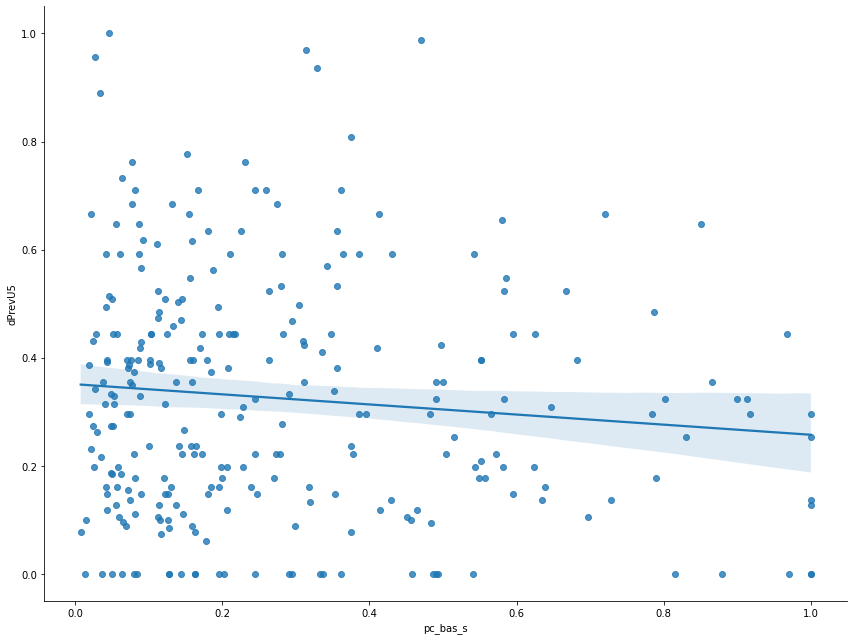

In [84]:
# Basic sanitation VS Diarrhoea

# Get complete dataset
data_g = dbf_c.copy()

x="pc_bas_s"
xthreshold = 0
y="dPrevU5"

g = sns.lmplot(
    data=data_g[data_g[x]>xthreshold],
    x=x, y=y,
    #hue="b_lev",
    height=9,
    aspect=1.33)

print("Sperman's rho:", stats.spearmanr(data_g[y][data_g[x]>xthreshold],data_g[x][data_g[x]>xthreshold]))

Sperman's rho: SpearmanrResult(correlation=-0.04249374057042117, pvalue=0.4280696506427839)


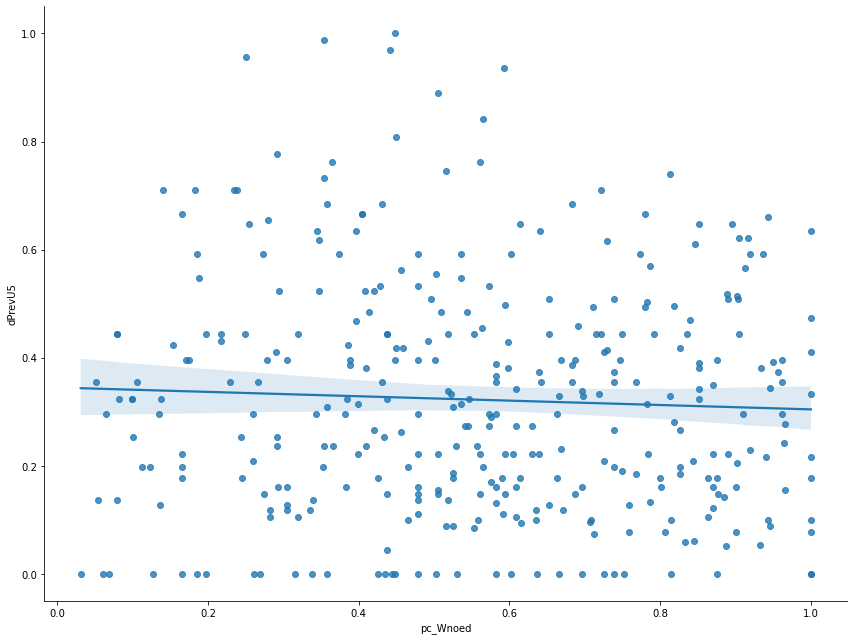

In [85]:
# Women's edu. VS Diarrhoea

# Get complete dataset
data_g = dbf_c.copy()

x="pc_Wnoed"
xthreshold = 0
y="dPrevU5"

g = sns.lmplot(
    data=data_g[data_g[x]>xthreshold],
    x=x, y=y,
    #hue="b_lev",
    height=9,
    aspect=1.33)

print("Sperman's rho:", stats.spearmanr(data_g[y][data_g[x]>xthreshold],data_g[x][data_g[x]>xthreshold]))